In [72]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
class Data():
    def __init__(self, filename):
        data = pd.read_pickle(filename)
        d_time = data.drop(columns=['X'])
        d_pos  = data.drop(columns=['T'])
        x = d_time.iloc[:, :].values
        y =  d_pos.iloc[:, :].values

        self.x = torch.tensor(x, requires_grad=True, dtype=torch.float)
        self.y = torch.tensor(y, requires_grad=True, dtype=torch.float)

    def __len__(self):
        return len(self.x)
    
    def __getparams__(self):
        return self.x, self.y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

see = 7

data  = Data('training-oha' + f'{see}' + '.pkl')  
vdata = Data('validation-oha' + f'{see}' + '.pkl') 
data.__len__()

12

In [74]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL

    def forward(self, x):
        out = self.linear(x)
        return out

model = OHAModel()
print(model)

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [75]:
optimiser = torch.optim.Adam(model.parameters())

In [76]:
# Custom loss function:
# Função base:

class OHALoss(nn.Module):
    def __init__(self):
        super(OHALoss, self).__init__()

    def df(self, output : torch.Tensor, x: torch.Tensor = None, order : int=1) -> torch.Tensor:
        for _ in range(order):
            output = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
            
        return output


    def forward(self, x_physics : torch.Tensor, physics_output : torch.Tensor, output : torch.Tensor, target : torch.Tensor, mi, k):
        # DE contribution
        LossDE = self.df(physics_output, x_physics, order=2) + (mi)*self.df(physics_output, x_physics, order=1) + (k)*physics_output 

        #MSE
        LossMSE = (target - output)

        Loss = LossDE.pow(2).mean() + LossMSE.pow(2).mean()

        return Loss





In [77]:
loss_func = OHALoss()
x_physics = torch.linspace(0, 10, 900, requires_grad=True).view(-1,1)

# x_physics determina o domínio da função que a rede pode prever. Desse modo, caso haja necessidade de uma previsão com x > 10, a rede não será capaz de definir \
# e outro treinamento deverá ser realizado

mi = 2.880
k  = 3.240

epochs = 200000
for epoch in range(epochs):
    optimiser.zero_grad()

    physics_outputs = model(x_physics)
    output = model(data.x)

    loss = loss_func(x_physics, physics_outputs, output, data.y, mi, k)
    
    loss.backward()
    optimiser.step()
    
    if epoch % 10000 == 0:
         print(f"Epoch: {epoch} - Loss: {float(loss.item()):>7f}")


Epoch: 0 - Loss: 0.544836
Epoch: 10000 - Loss: 0.000001
Epoch: 20000 - Loss: 0.000001
Epoch: 30000 - Loss: 0.000000
Epoch: 40000 - Loss: 0.000000
Epoch: 50000 - Loss: 0.000000
Epoch: 60000 - Loss: 0.000000
Epoch: 70000 - Loss: 0.000078
Epoch: 80000 - Loss: 0.000000
Epoch: 90000 - Loss: 0.000000
Epoch: 100000 - Loss: 0.000002
Epoch: 110000 - Loss: 0.000001
Epoch: 120000 - Loss: 0.000000
Epoch: 130000 - Loss: 0.000000
Epoch: 140000 - Loss: 0.000000
Epoch: 150000 - Loss: 0.000000
Epoch: 160000 - Loss: 0.000000
Epoch: 170000 - Loss: 0.000000
Epoch: 180000 - Loss: 0.000000
Epoch: 190000 - Loss: 0.000000


In [78]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


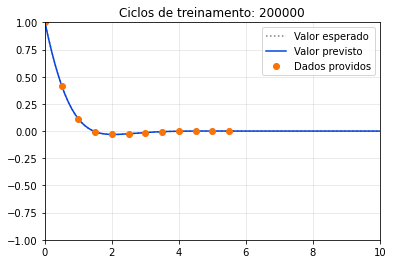

In [79]:
epochs = 200000

model = OHAModel()
model.load_state_dict(torch.load("model.pth"))

predicted = model(vdata.x)
vx = vdata.x.detach().numpy()
vy = vdata.y.detach().numpy()

x = data.x.detach().numpy()
y = data.y.detach().numpy()

plt.plot(vx, vy, color='tab:gray', linestyle=':', label='Valor esperado')
plt.plot(vx, predicted.detach().numpy(), color='xkcd:blue', linestyle='solid', label = 'Valor previsto')
plt.plot(x, y, color='xkcd:orange', marker='o', linestyle='none', label = 'Dados providos')
plt.xlim([0, 10])
plt.ylim([-1, 1])
plt.title(f'Ciclos de treinamento: {epochs}')
plt.legend(loc=1)
plt.grid(True, alpha=0.3)
plt.savefig('grafico-oha.jpg')
plt.show()

# Cálculo do erro

In [80]:
previsto = predicted.detach().numpy()[:101]
esperado = vdata.y.detach().numpy()[:101]

erro = previsto - esperado
erro_maximo = erro[np.argmax(erro)][0]

print(f'Erro máximo encontrado na rede: {erro_maximo :.10f}')

erro_medio = np.mean(erro)

print(f'Erro médio encontrado na rede: {erro_medio :.10f}')

erro_quadratico_medio = np.power(erro, 2)
erro_quadratico_medio = np.mean(erro_quadratico_medio)

print(f'Erro quadrático médio encontrado na rede: {erro_quadratico_medio :.10f}')

Erro máximo encontrado na rede: 0.0001980066
Erro médio encontrado na rede: 0.0000024706
Erro quadrático médio encontrado na rede: 0.0000000034
